# Initial EDA and Workplan for Interconnect's churn prediction model

Interconnect, a leading telecom operator, seeks to proactively address customer churn by forecasting which clients are most likely to leave their services. To achieve this, the company aims to leverage advanced machine learning techniques to identify the key factors driving customer attrition and predict which customers are at the highest risk of churning.

The objective of this project is to develop and thoroughly evaluate a machine learning model that can accurately predict customer churn. This model will empower Interconnect to implement targeted retention strategies, minimize churn rates, and enhance overall customer satisfaction.

### Overview:
Data Collection: The dataset consists of customer data from the telecom operator Interconnect. This includes information about customer demographics, contract details, payment methods, and usage of various telecom services. The data is collected from Interconnect’s operational systems and reflects the behavior and characteristics of both churning and non-churning customers.

Preprocessing: The data will be preprocessed to prepare it for model training. This involves encoding categorical variables, scaling numerical features, and creating new features such as customer tenure and a binary churn indicator. The data will also be balanced to address any class imbalance between churning and non-churning customers.

Model Building: We will explore and build various machine learning models, including Logistic Regression, Decision Trees, Random Forest, Gradient Boosting Machines, and more advanced models like XGBoost and Neural Networks. The models will be trained to predict whether a customer will churn based on the available features.

Model Evaluation: The model's performance will be evaluated using metrics AUC-ROC, and accuracy. We will also analyze feature importance to understand which factors contribute most to customer churn. Ensuring the model is unbiased and generalizes well across different customer segments will be a priority.

Project Objective: The primary goal of this project is to build and evaluate a robust machine learning model that can accurately predict which customers are likely to churn. This model will enable Interconnect to take proactive measures, such as targeted promotions, to retain customers and reduce churn rates, ultimately contributing to better customer satisfaction and business sustainability.

## Initialization

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import re
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import  StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

import xgboost as xgb
import lightgbm as lgb
import catboost as catgb
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l2


## Loading Data

In [2]:
contract_df = pd.read_csv('./datasets/contract.csv')
internet_df = pd.read_csv('./datasets/internet.csv')
personal_df = pd.read_csv('./datasets/personal.csv')
phone_df = pd.read_csv('./datasets/phone.csv')

In [3]:
contract_df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [4]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


'contract_df' has 7043 observations, with no missing values. Although the datatypes are appropriate for the EDA, they will be changed for the model training section with all non-numeric values being encoded. The column names will also be changed to remove uppercase letters and include underscores. A new column 'churn' will be created from 'end_date', and both 'begin_date' and 'end_date' will be changed to datetime.

In [5]:
personal_df

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [6]:
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


'personal_df' also has 7043 observations, with no missing values. Although the datatypes are appropriate for the EDA, they will be changed for the model training section with all non-numeric values being encoded. The column names will also be changed to remove uppercase letters and include underscores.

In [7]:
internet_df

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [8]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


'internet_df' also has 5517 observations, with no missing values. This differs from the df's above, which is because not all customers have internet services. Although the datatypes are appropriate for the EDA, they will be changed for the model training section with all non-numeric values being encoded. The column names will also be changed to remove uppercase letters and include underscores.

In [9]:
phone_df

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [10]:
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


'phone_df' also has 6361 observations, with no missing values. This differs from the df's above, which is because not all customers have phone services. This will be investigated below. Although the datatypes are appropriate for the EDA, they will be changed for the model training section with all non-numeric values being encoded. The column names will also be changed to remove uppercase letters and include underscores.

## Data Preperation

In [11]:
main_df = pd.merge(contract_df, internet_df, on='customerID', how='left')
main_df = pd.merge(main_df, phone_df, on='customerID', how='left')
main_df = pd.merge(main_df, personal_df, on='customerID', how='left')

In [12]:
def camel_to_snake(name):
    name = re.sub(r'(?<!^)(?<![A-Z])(?=[A-Z])', '_', name)
    return name.lower()

main_df.columns = [camel_to_snake(col) for col in main_df.columns]

In [13]:
main_df['churn'] = np.where(main_df['end_date'] == 'No', 'No', 'Yes')
main_df.loc[main_df['end_date'] == 'No', 'end_date'] = '2022-12-01 00:00:00'
main_df['end_date'] = pd.to_datetime(main_df['end_date'])
main_df['begin_date'] = pd.to_datetime(main_df['begin_date'])

All DataFrames have been merged into a single DataFrame using customer IDs as the key. During this process, some missing values were introduced due to customers not subscribing to certain services, which will be addressed later.

A new column named 'churn' was created based on the 'end_date' column to indicate whether a customer has left the company. To facilitate this, all 'end_date' values that were initially 'No' (indicating ongoing service) were replaced with a placeholder date of '2022-12-01'—a date significantly later than any other dates in the dataset. This step ensured that 'end_date' could be uniformly converted to a datetime format.

Both 'end_date' and 'begin_date' columns were subsequently converted to the datetime format.

In [14]:
main_df

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,gender,senior_citizen,partner,dependents,churn
0,7590-VHVEG,2020-01-01,2022-12-01,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,...,No,No,No,No,NaN,Female,0,Yes,No,No
1,5575-GNVDE,2017-04-01,2022-12-01,One year,No,Mailed check,56.95,1889.5,DSL,Yes,...,Yes,No,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,...,No,No,No,No,No,Male,0,No,No,Yes
3,7795-CFOCW,2016-05-01,2022-12-01,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,...,Yes,Yes,No,No,NaN,Male,0,No,No,No
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,...,No,No,No,No,No,Female,0,No,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2022-12-01,One year,Yes,Mailed check,84.80,1990.5,DSL,Yes,...,Yes,Yes,Yes,Yes,Yes,Male,0,Yes,Yes,No
7039,2234-XADUH,2014-02-01,2022-12-01,One year,Yes,Credit card (automatic),103.20,7362.9,Fiber optic,No,...,Yes,No,Yes,Yes,Yes,Female,0,Yes,Yes,No
7040,4801-JZAZL,2019-03-01,2022-12-01,Month-to-month,Yes,Electronic check,29.60,346.45,DSL,Yes,...,No,No,No,No,NaN,Female,0,Yes,Yes,No
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.6,Fiber optic,No,...,No,No,No,No,Yes,Male,1,Yes,No,Yes


## Missing Values

In [15]:
main_df.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
gender                  0
senior_citizen          0
partner                 0
dependents              0
churn                   0
dtype: int64

In [16]:
len(main_df) - len(internet_df)

1526

In [17]:
len(main_df) - len(phone_df)

682

In [18]:
main_df = main_df.fillna('Not Subscribed')

The missing values in main_df resulted from merging data where not all customers subscribed to certain services. By subtracting the number of customers who have each service from the total number of customers, it was confirmed that these missing values correspond to customers who did not subscribe to those services. To address this, all missing values have been filled with 'Not Subscribed'.

## Duplicate Values

In [19]:
main_df.duplicated().sum()

0

In [20]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
 8   internet_service   7043 non-null   object        
 9   online_security    7043 non-null   object        
 10  online_backup      7043 non-null   object        
 11  device_protection  7043 non-null   object        
 12  tech_support       7043 non-null   object        
 13  streaming_tv       7043 non-null   object        
 14  streamin

No duplicate values found.

# EDA

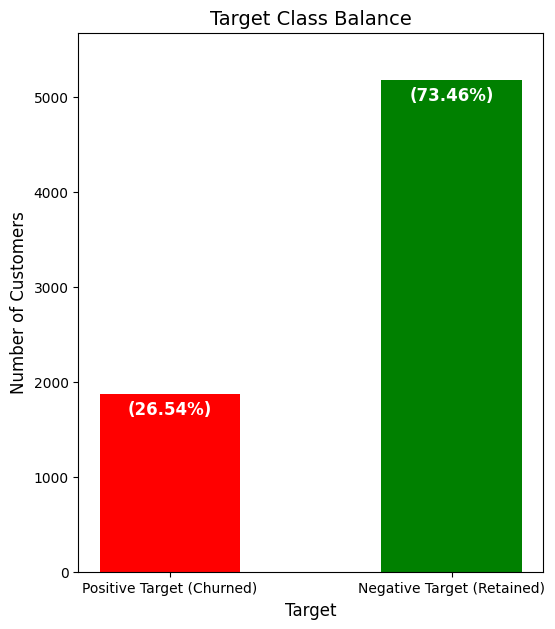

Out of the 7043 customers in the database:
1869 have churned (26.54%)
5174 have been retained (73.46%).



In [16]:
def plot_target_class_balance(df, target_column):

    pos_target_count = df[df[target_column] == 'Yes'].shape[0]
    neg_target_count = df[df[target_column] == 'No'].shape[0]
    total_count = len(df)

    target_values = [pos_target_count, neg_target_count]
    target_labels = ['Positive Target (Churned)', 'Negative Target (Retained)']
    
    plt.figure(figsize=(6, 7))
    bars = plt.bar(target_labels, target_values, color=['red', 'green'], width=0.5)

    for bar, value in zip(bars, target_values):
        percentage = (value / total_count) * 100
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 250, 
                 f'{value}\n({percentage:.2f}%)', ha='center', va='bottom', fontsize=12, color='white', weight='bold')

    plt.xlabel('Target', fontsize=12)
    plt.ylabel('Number of Customers', fontsize=12)
    plt.ylim(0, max(target_values) + 500)
    plt.title('Target Class Balance', fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

    print(f"Out of the {total_count} customers in the database:\n"
          f"{pos_target_count} have churned ({pos_target_count / total_count:.2%})\n"
          f"{neg_target_count} have been retained ({neg_target_count / total_count:.2%}).\n")

plot_target_class_balance(main_df, 'churn')

Because of the class imbalance (1:3), I will upsample the positive target below for the model training.

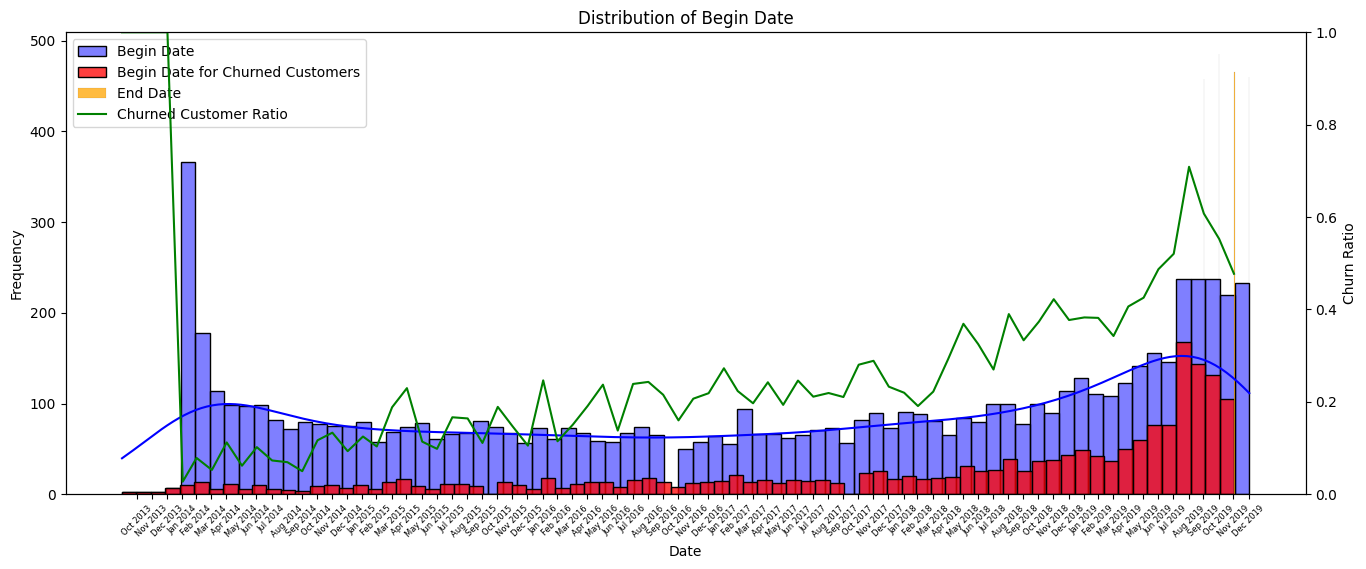

In [22]:
date_range = pd.date_range(start=main_df['begin_date'].min(), end='2020-01-01', freq='M')

fig, ax1 = plt.subplots(figsize=(16, 6))

sns.histplot(
    data=main_df[main_df['begin_date'] <= '2020-01-01'], 
    x='begin_date', 
    bins=77,
    color='blue', 
    label='Begin Date', 
    kde=True
)

sns.histplot(
    data=main_df[(main_df['begin_date'] <= '2020-01-01') & (main_df['end_date'] != '2022-12-01')], 
    x='begin_date', 
    bins=77, 
    color='red', 
    label='Begin Date for Churned Customers'
)

sns.histplot(
    data=main_df[(main_df['end_date'] <= '2020-01-01') & (main_df['end_date'] != '2022-12-01')], 
    x='end_date', 
    bins=77, 
    color='orange', 
    label='End Date'
)

ax1.set_xlabel('Date')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Begin Date')

ax2 = ax1.twinx()
churn_ratio = (
    main_df[(main_df['begin_date'] <= '2019-12-31') & (main_df['end_date'] != '2022-12-01')]
    ['begin_date'].dt.to_period('M').value_counts() / 
    main_df[main_df['begin_date'] <= '2019-12-31']
    ['begin_date'].dt.to_period('M').value_counts()
)
ax2.plot(churn_ratio.index.to_timestamp(), churn_ratio.values, color='green', label='Churned Customer Ratio')
ax2.set_ylabel('Churn Ratio')
ax2.set_ylim(0, 1)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2)

ax1.set_xticks(date_range)
ax1.set_xticklabels([date.strftime('%b %Y') for date in date_range], rotation=45, fontsize=6)

plt.show()

There was a big jump in new customers starting service in late 2013 and early 2014, and even though a lot of people signed up, the churn rate stayed pretty low. After that initial surge, things leveled out, with a more consistent flow of new customers over the next few years.

The red bars, which show the churned customers, are scattered throughout the timeline, but they really start to stand out around 2018-2019. During this period, the churn ratio (green line) begins to climb noticeably, hitting a peak towards the end. This suggests that the company has been losing customers faster than it's gaining them in recent years.

In [23]:
churned_df = main_df[main_df['churn'] == 'Yes']
non_churned_df = main_df[main_df['churn'] == 'No']

In [24]:
def plot_percentage_distribution(df, feature, ax):
    feature_churn_counts = df.groupby(['churn', feature]).size().unstack().fillna(0)
    feature_churn_counts = feature_churn_counts[feature_churn_counts.sum(axis=0).sort_values(ascending=False).index]

    feature_churn_percentages = feature_churn_counts.div(feature_churn_counts.sum(axis=1), axis=0) * 100

    feature_churn_percentages.plot(kind='bar', stacked=True, ax=ax, colormap='Pastel1')

    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', label_type='center')

    ax.set_title(feature)
    ax.set_xlabel('Churn Status')
    ax.set_ylabel('Percentage (%)')
    ax.set_xticks(range(len(feature_churn_percentages.index)))
    ax.set_xticklabels(['Not Churned', 'Churned'], rotation=0)
    ax.legend(title=feature, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

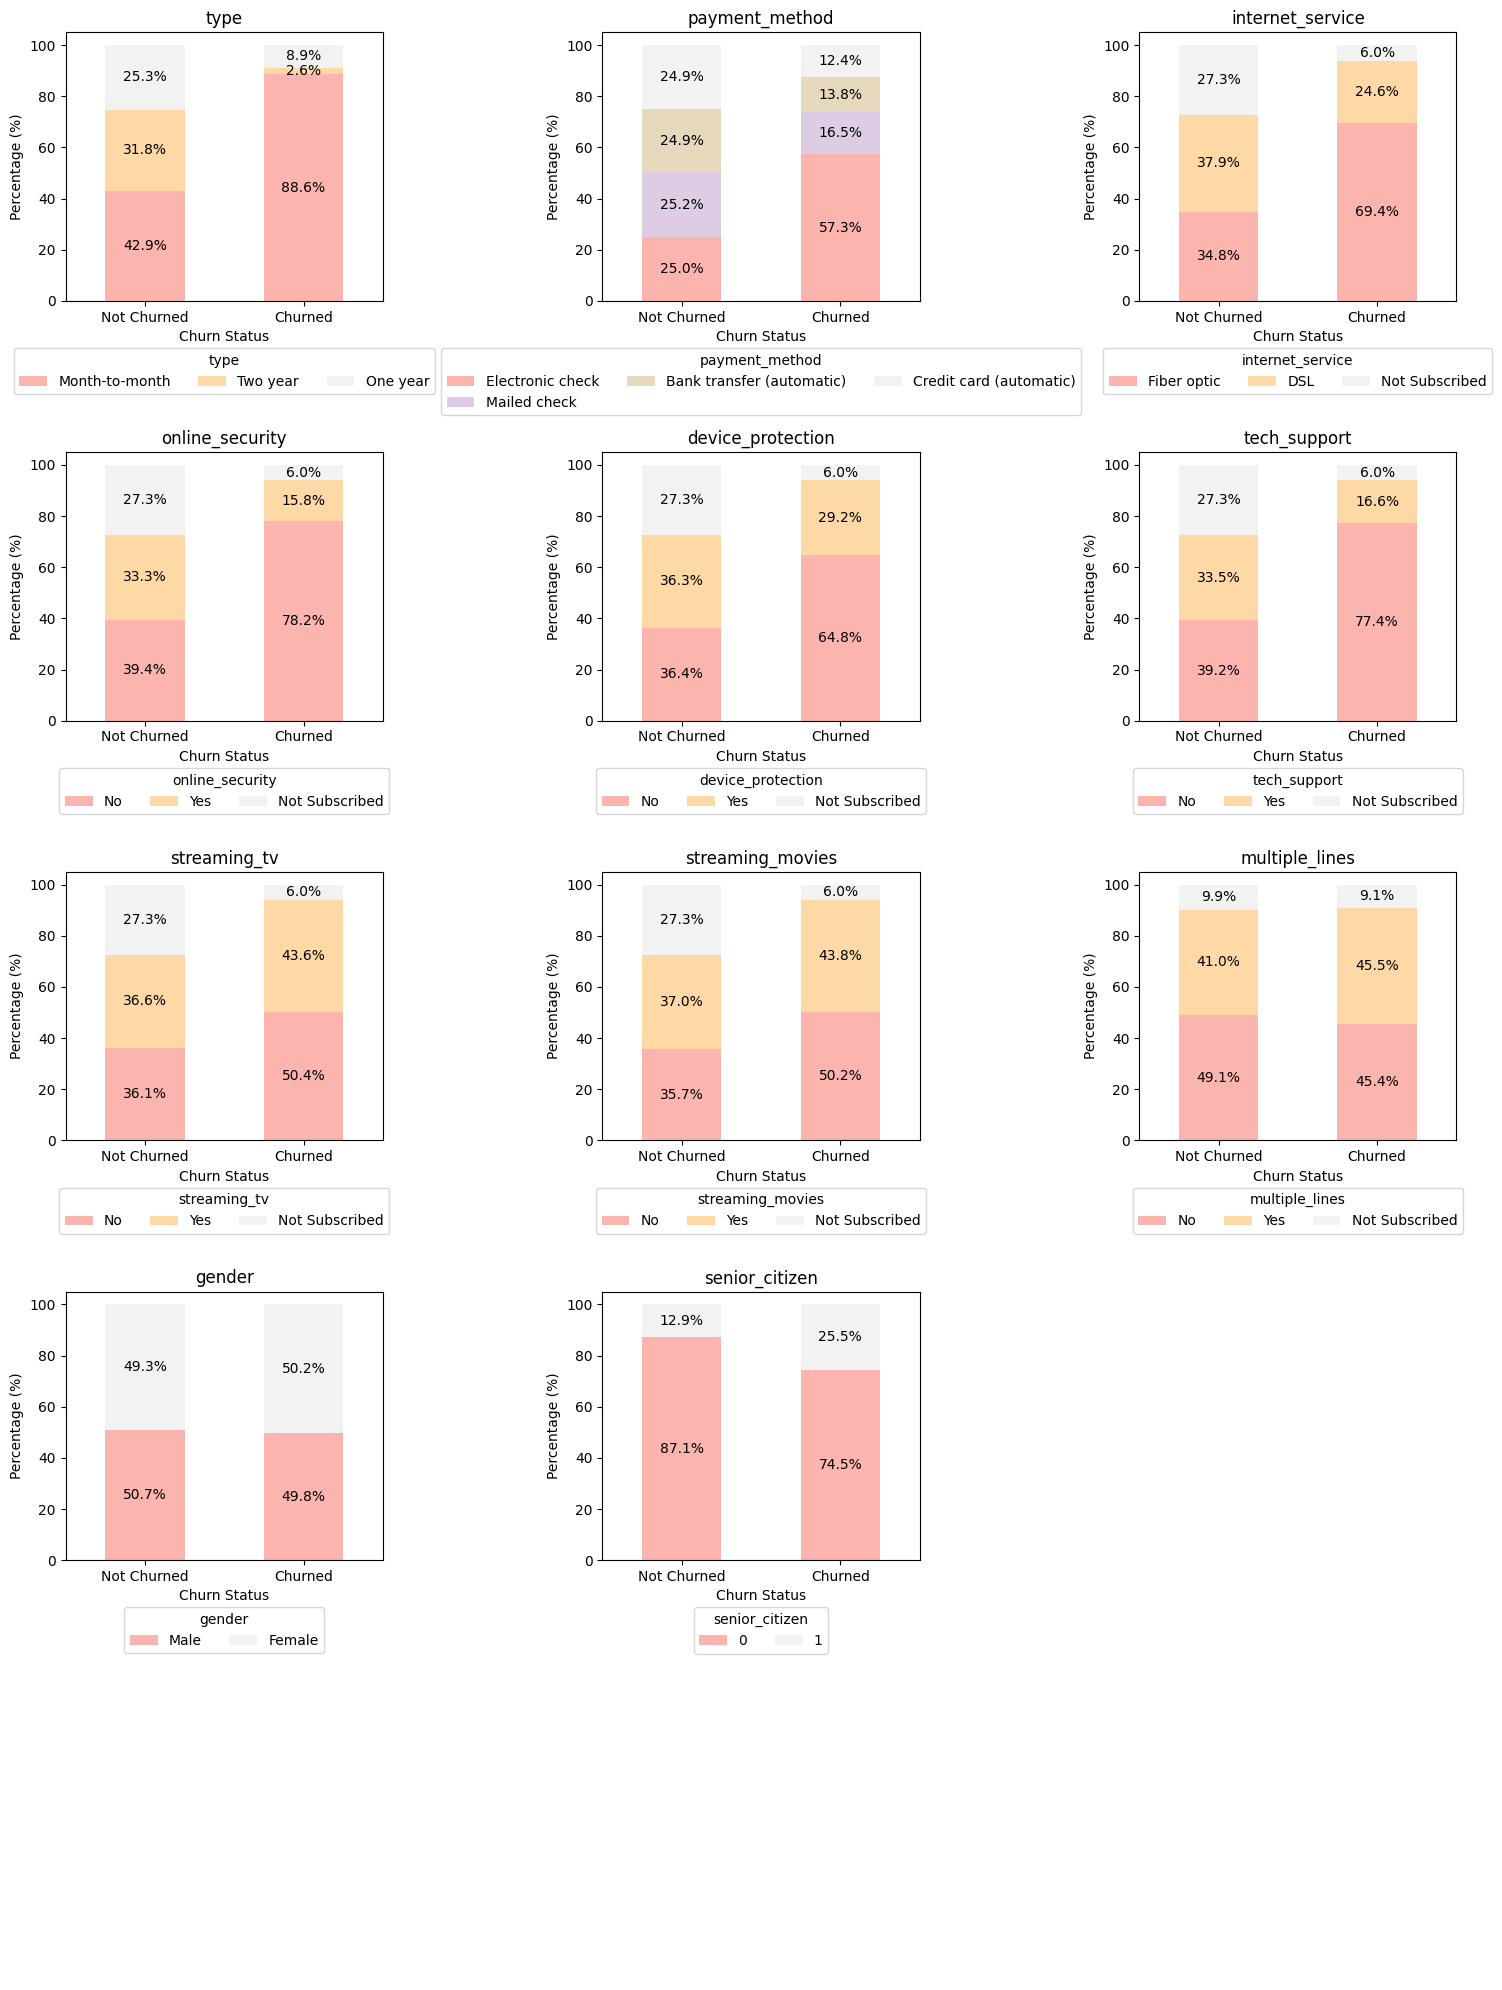

In [25]:
features = ['type', 'payment_method', 'internet_service', 'online_security', 'device_protection',
            'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines', 'gender', 'senior_citizen']

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 20))
axes = axes.flatten()

for i, feature in enumerate(features):
    plot_percentage_distribution(main_df, feature, axes[i])

for j in range(len(features), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Contract Type:
- High Churn Risk: Month-to-month contracts have a significantly higher churn rate. 88.6% of churned customers were on month-to-month contracts.
- Lower Churn Risk: Customers with one-year or two-year contracts are much less likely to churn, with only 8.9% and 2.6% of churned customers on these contracts, respectively.

Payment Method:
- Predominant Method: Electronic checks are the most common payment method among churned customers, used by 57%.
- Other Methods: The remaining payment methods (e.g., credit card, mailed check, bank transfer) account for approximately 15% each among churned customers.

Internet Service:
- Fiber Optic: The most common internet service among churned customers, with 69% using Fiber Optic.
- DSL: 24% of churned customers used DSL.
- Not Subscribed: Only 4% of churned customers were not subscribed to an internet service.

Additional Internet Services:
- High Opt-Out Rates: A significant portion of churned customers opted out of additional services like online security, device protection, and streaming services, with opt-out rates ranging from 50% to 78%.

Gender and Multiple Lines:
- Even Distribution: Churn rates are fairly evenly distributed between genders and among customers with multiple lines.

Senior Citizens:
- Compared to the non-churned customers, elder citizens account for 25% of churned customers compared to the 13% that account for the non churned customers.


In [26]:
corr_df = main_df.copy()

In [27]:
corr_df.loc[:, 'type'] = corr_df['type'].replace({'Month-to-month': 0, 'One year': 1, 'Two year': 2})
churned_df.loc[:, 'type'] = churned_df['type'].replace({'Month-to-month': 0, 'One year': 1, 'Two year': 2})
non_churned_df.loc[:, 'type'] = non_churned_df['type'].replace({'Month-to-month': 0, 'One year': 1, 'Two year': 2})

corr_df.loc[:, 'internet_service'] = corr_df['internet_service'].replace({'Fiber optic': 2, 'DSL': 1, 'Not Subscribed': 0})
churned_df.loc[:, 'internet_service'] = churned_df['internet_service'].replace({'Fiber optic': 2, 'DSL': 1, 'Not Subscribed': 0})
non_churned_df.loc[:, 'internet_service'] = non_churned_df['internet_service'].replace({'Fiber optic': 2, 'DSL': 1, 'Not Subscribed': 0})

In [28]:
binary_list = ['paperless_billing', 'online_security', 'online_backup', 
                     'device_protection', 'tech_support', 'streaming_tv', 
                     'streaming_movies', 'multiple_lines', 'partner', 
                     'dependents', 'senior_citizen', 'type', 'internet_service', 'churn']

def corr_plot(ax, df, title):
    binary_df = df[binary_list]
    binary_df = binary_df.replace({'Yes': 1, 'No': 0, 'Not Subscribed': -1})
    corr_matrix = binary_df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='viridis', vmin=-1, vmax=1, ax=ax, annot_kws={'size':8}, fmt='.2f')
    ax.set_title(title)

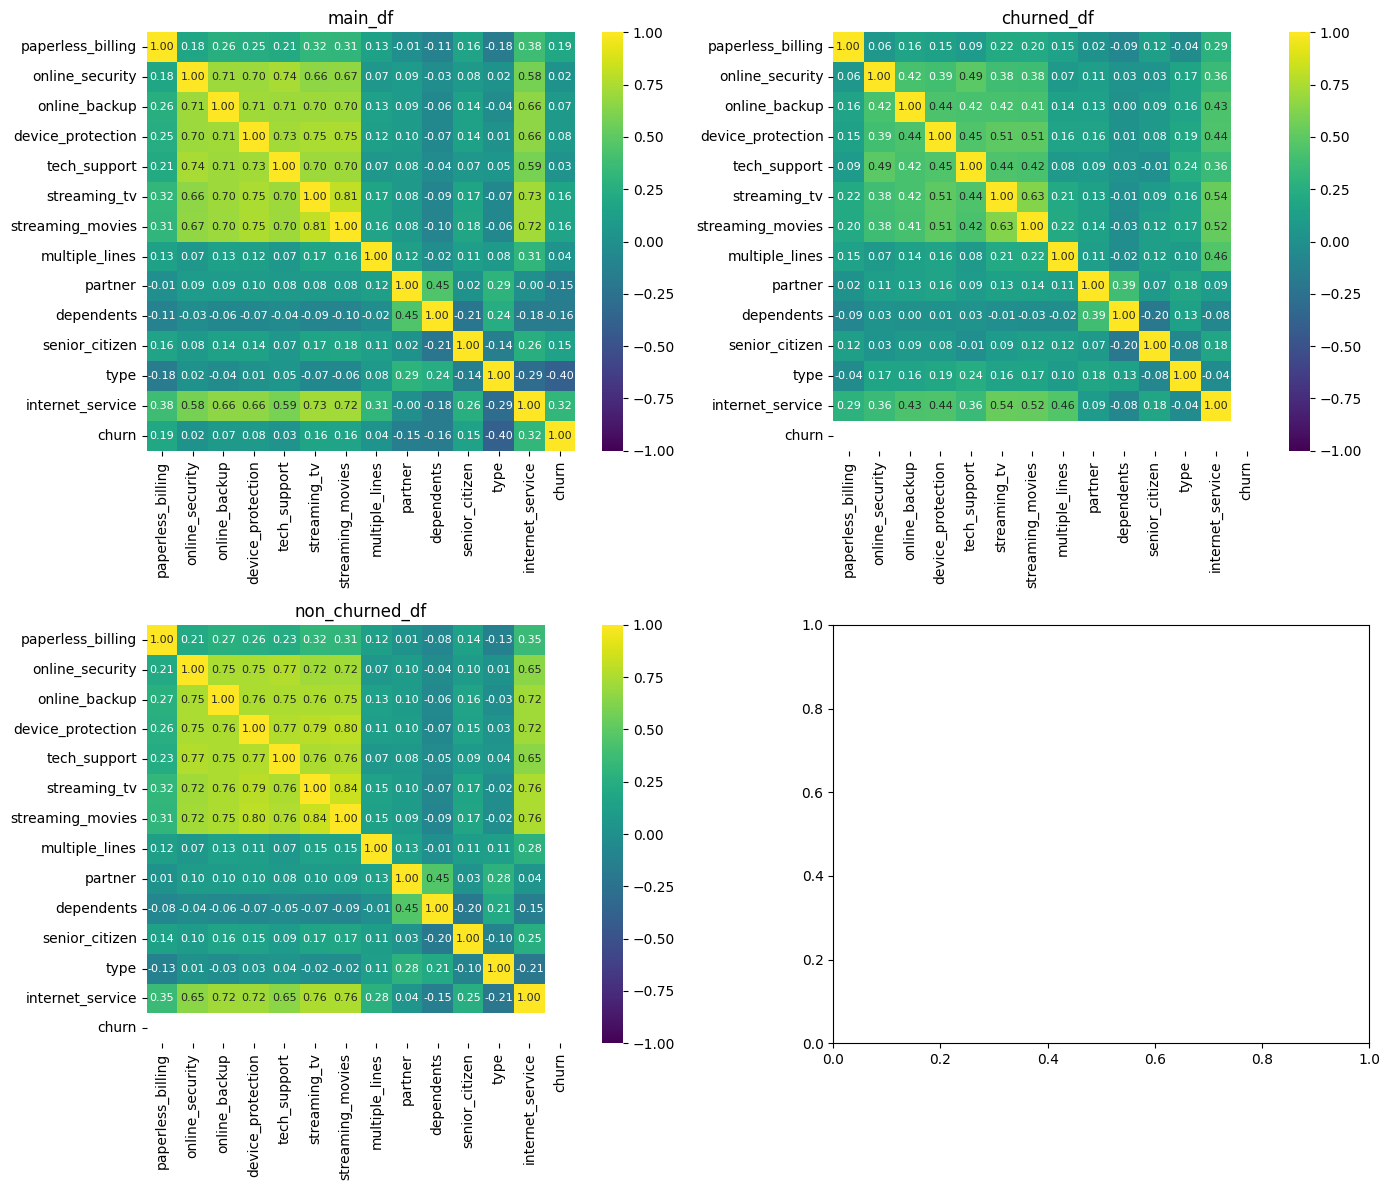

In [29]:
dfs = [corr_df, churned_df, non_churned_df]
df_names = ['main_df', 'churned_df', 'non_churned_df']

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (data, name) in enumerate(zip(dfs, df_names)):
    corr_plot(axes[idx], data, name)

plt.tight_layout()
plt.show()

The correlation between churn and most features is relatively weak, with the highest absolute value of correlation being -0.40 for contract type. This suggests that no single feature has a strong linear relationship with churn. Internet Service had the 2nd highest correlation with 0.32.

# Model Exploration

In [19]:
main_df

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,gender,senior_citizen,partner,dependents,churn
0,7590-VHVEG,2020-01-01,2022-12-01,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,...,No,No,No,No,Not Subscribed,Female,0,Yes,No,No
1,5575-GNVDE,2017-04-01,2022-12-01,One year,No,Mailed check,56.95,1889.5,DSL,Yes,...,Yes,No,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,...,No,No,No,No,No,Male,0,No,No,Yes
3,7795-CFOCW,2016-05-01,2022-12-01,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,...,Yes,Yes,No,No,Not Subscribed,Male,0,No,No,No
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,...,No,No,No,No,No,Female,0,No,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2022-12-01,One year,Yes,Mailed check,84.80,1990.5,DSL,Yes,...,Yes,Yes,Yes,Yes,Yes,Male,0,Yes,Yes,No
7039,2234-XADUH,2014-02-01,2022-12-01,One year,Yes,Credit card (automatic),103.20,7362.9,Fiber optic,No,...,Yes,No,Yes,Yes,Yes,Female,0,Yes,Yes,No
7040,4801-JZAZL,2019-03-01,2022-12-01,Month-to-month,Yes,Electronic check,29.60,346.45,DSL,Yes,...,No,No,No,No,Not Subscribed,Female,0,Yes,Yes,No
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.6,Fiber optic,No,...,No,No,No,No,Yes,Male,1,Yes,No,Yes


In [20]:
ml_df = main_df.copy()
ml_df = ml_df.drop(columns=['customer_id', 'end_date', 'total_charges'])

In [21]:
ml_df['begin_date'] = ml_df['begin_date'].dt.strftime('%Y%m').astype('int64')
ml_df['begin_date'] = ml_df['begin_date'] - 200000

## Encoding

In [23]:
ohe_df = pd.get_dummies(ml_df, drop_first=True)
ohe_df = ohe_df.astype(int)

In [25]:
ohe_df.columns = ohe_df.columns.str.lower().str.replace(' ', '_')
ohe_df


,begin_date,monthly_charges,senior_citizen,type_one_year,type_two_year,paperless_billing_yes,payment_method_credit_card_(automatic),payment_method_electronic_check,payment_method_mailed_check,internet_service_fiber_optic,...,streaming_tv_not_subscribed,streaming_tv_yes,streaming_movies_not_subscribed,streaming_movies_yes,multiple_lines_not_subscribed,multiple_lines_yes,gender_male,partner_yes,dependents_yes,churn_yes
0,2001,29,0,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
1,1704,56,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,1910,53,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
3,1605,42,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4,1909,70,0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1802,84,0,1,0,1,0,0,1,0,...,0,1,0,1,0,1,1,1,1,0
7039,1402,103,0,1,0,1,1,0,0,1,...,0,1,0,1,0,1,0,1,1,0
7040,1903,29,0,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,1,1,0
7041,1907,74,1,0,0,1,0,0,1,1,...,0,0,0,0,0,1,1,1,0,1


In [20]:
categorical_columns = ['type', 'paperless_billing', 'payment_method', 
                     'internet_service', 'online_security', 'online_backup', 
                     'device_protection', 'tech_support', 'streaming_tv', 
                     'streaming_movies', 'multiple_lines', 'gender', 'partner', 
                     'dependents', 'churn']

le = LabelEncoder()

for column in categorical_columns:
    ml_df[column] = le.fit_transform(ml_df[column])
ml_df

,begin_date,type,paperless_billing,payment_method,monthly_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,gender,senior_citizen,partner,dependents,churn
0,2001,0,1,2,29.85,0,0,2,0,0,0,0,1,0,0,1,0,0
1,1704,1,0,3,56.95,0,2,0,2,0,0,0,0,1,0,0,0,0
2,1910,0,1,3,53.85,0,2,2,0,0,0,0,0,1,0,0,0,1
3,1605,1,0,0,42.30,0,2,0,2,2,0,0,1,1,0,0,0,0
4,1909,0,1,2,70.70,1,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1802,1,1,3,84.80,0,2,0,2,2,2,2,2,1,0,1,1,0
7039,1402,1,1,1,103.20,1,0,2,2,0,2,2,2,0,0,1,1,0
7040,1903,0,1,2,29.60,0,2,0,0,0,0,0,1,0,0,1,1,0
7041,1907,0,1,3,74.40,1,0,0,0,0,0,0,2,1,1,1,0,1


## Data Splitting and Upsampling

In [46]:
target = ohe_df['churn_yes']

features = ohe_df.drop('churn_yes', axis=1)

features_train, features_temp, target_train, target_temp = train_test_split(
    features, target, test_size=0.4, random_state=12345
)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_temp, target_temp, test_size=0.5, random_state=12345
)

## Data Scaling

In [27]:
numeric = [
    'begin_date',
    'monthly_charges',
    'senior_citizen',
    'type_one_year',
    'type_two_year',
    'paperless_billing_yes',
    'payment_method_credit_card_(automatic)',
    'payment_method_electronic_check',
    'payment_method_mailed_check',
    'internet_service_fiber_optic',
    'streaming_tv_not_subscribed',
    'streaming_tv_yes',
    'streaming_movies_not_subscribed',
    'streaming_movies_yes',
    'multiple_lines_not_subscribed',
    'multiple_lines_yes',
    'gender_male',
    'partner_yes',
    'dependents_yes',
    'tech_support_yes'
]

In [47]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.fit_transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

print(features_train.head())

      begin_date  monthly_charges  senior_citizen  type_one_year  \
836    -1.419344         0.221321       -0.449435       1.919384   
1005   -0.925641         1.015897        2.225018       1.919384   
4220   -0.935820        -1.500258       -0.449435       1.919384   
6543   -1.419344        -0.341503       -0.449435       1.919384   
272     1.120428        -1.334722       -0.449435      -0.521000   

      type_two_year  paperless_billing_yes  \
836       -0.567055              -1.210369   
1005      -0.567055               0.826194   
4220      -0.567055              -1.210369   
6543      -0.567055              -1.210369   
272       -0.567055              -1.210369   

      payment_method_credit_card_(automatic)  payment_method_electronic_check  \
836                                 1.861766                         -0.69534   
1005                                1.861766                         -0.69534   
4220                               -0.537124                         -0

## Basic Model Training and Evaluation

In [48]:
def train_model(model_name, model, features_train, features_valid, target_train, target_valid, verbose=False):
    start_time = time.time()
    
    if model_name == 'CatBoost':
        model.fit(features_train, target_train, verbose=250)
    else:
        model.fit(features_train, target_train)
    
    probabilities_valid = model.predict_proba(features_valid)[:, 1]
    
    roc_auc = roc_auc_score(target_valid, probabilities_valid)
    
    time_taken = round(time.time() - start_time, 3)
    
    if verbose:
        print(f"{model_name} - ROC-AUC: {roc_auc:.4f}, Time Taken: {time_taken} seconds")
    
    return roc_auc, time_taken

In [49]:
rs = 12345

models = {
    'LogisticRegression': LogisticRegression(random_state=rs),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=rs),
    'RandomForestClassifier': RandomForestClassifier(random_state=rs),
    'XGBoost': xgb.XGBClassifier(random_state=rs),
    'LightGBM': lgb.LGBMClassifier(random_state=rs),
    'CatBoost': catgb.CatBoostClassifier(random_state=rs)
}

results = []

for model_name, model in models.items():
    roc_auc, time_taken = train_model(model_name, model, features_train, features_valid, target_train, target_valid)
    results.append({'Model': model_name, 'ROC-AUC': roc_auc, 'Time Taken': time_taken})

base_result_df = pd.DataFrame(results)

[LightGBM] [Info] Number of positive: 1101, number of negative: 3124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 242
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260592 -> initscore=-1.042895
[LightGBM] [Info] Start training from score -1.042895
Learning rate set to 0.019062
0:	learn: 0.6792155	total: 4.27ms	remaining: 4.27s
250:	learn: 0.3642287	total: 1.06s	remaining: 3.17s
500:	learn: 0.3287896	total: 1.96s	remaining: 1.96s
750:	learn: 0.3020478	total: 2.73s	remaining: 905ms
999:	learn: 0.2793394	total: 3.46s	remaining: 0us


In [50]:
start_time = time.time()

model = Sequential()
model.add(Dense(64, input_dim=features_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[AUC()])

history = model.fit(features_train, target_train, epochs=50, batch_size=32, validation_data=(features_train, target_train), callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

time_taken = round(time.time() - start_time, 3)
y_pred_prob = model.predict(features_valid).ravel()

roc_auc = roc_auc_score(target_valid, y_pred_prob)

print(f'ROC-AUC: {roc_auc:.4f}')
print(f'Training Time: {time_taken:.2f} seconds')

keras_result = []
keras_result.append({'Model': 'Keras', 'ROC-AUC': roc_auc, 'Time Taken': time_taken})
keras_result = pd.DataFrame(keras_result)

Epoch 1/50


c:\Users\crisl\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - auc_3: 0.5910 - loss: 1.5359 - val_auc_3: 0.8151 - val_loss: 1.0306
Epoch 2/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc_3: 0.7830 - loss: 0.9695 - val_auc_3: 0.8306 - val_loss: 0.7380
Epoch 3/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc_3: 0.7981 - loss: 0.7317 - val_auc_3: 0.8356 - val_loss: 0.6043
Epoch 4/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc_3: 0.8184 - loss: 0.6050 - val_auc_3: 0.8383 - val_loss: 0.5343
Epoch 5/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc_3: 0.8157 - loss: 0.5364 - val_auc_3: 0.8400 - val_loss: 0.5005
Epoch 6/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc_3: 0.8270 - loss: 0.5048 - val_auc_3: 0.8413 - val_loss: 0.4831
Epoch 7/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc_3: 0.8262 - loss: 0.4922 - val_auc_3: 0.8420 - val_loss: 0.4717
Epoch 8/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc_3: 0.8264 - loss: 0.4851 - val_auc_3: 0.8412 - val_loss: 0.4666
Epoch 9/50
133/133 ━━━━━━━━━━━━━━━━

In [51]:
combined_results_df = pd.concat([base_result_df, keras_result], ignore_index=True)
combined_results_df

,Model,ROC-AUC,Time Taken
0,LogisticRegression,0.838411,0.108
1,DecisionTreeClassifier,0.689834,0.043
2,RandomForestClassifier,0.836881,0.633
3,XGBoost,0.828275,0.122
4,LightGBM,0.842552,0.084
5,CatBoost,0.855005,3.675
6,Keras,0.839767,20.159


- Best Performing Model:

XGBoost.

With an ROC-AUC score of 0.8601, XGBoost stands out as the top-performing model among those tested. It demonstrates a strong ability to differentiate between churn and non-churn cases while maintaining a relatively efficient time cost of 0.064 seconds. XGBoost offers a good balance between accuracy and computational efficiency.

- Second Best Performer:

RandomForestClassifier.

This model achieves an ROC-AUC score of 0.8568, showcasing high performance in predicting churn. However, it takes 0.836 seconds to run, which is considerably longer than XGBoost. While it performs slightly better than XGBoost in terms of ROC-AUC, the increased time cost may be a factor to consider.

- Third Place:

LightGBM.

With an ROC-AUC score of 0.8515, LightGBM performs well, though it does not surpass XGBoost or RandomForest in accuracy. However, it is still relatively time-efficient at 0.072 seconds, making it a strong contender if both performance and speed are important.

## Model Finetuning

In [37]:
def train_model(model_name, model, features_train, features_valid, target_train, target_valid, best_params=None, verbose=False):
    start_time = time.time()
    
    if model_name == 'CatBoost':
        model.fit(features_train, target_train, verbose=250)
    else:
        model.fit(features_train, target_train)
    
    probabilities_valid = model.predict_proba(features_valid)[:, 1]
    roc_auc = roc_auc_score(target_valid, probabilities_valid)
    
    time_taken = round(time.time() - start_time, 3)
    
    if verbose:
        print(f"{model_name} - ROC-AUC: {roc_auc:.4f}, Time Taken: {time_taken} seconds")
    
    return roc_auc, time_taken, best_params

In [38]:
rs = 12345

models = {
    'LogisticRegression': LogisticRegression(random_state=rs),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=rs),
    'RandomForestClassifier': RandomForestClassifier(random_state=rs),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=rs),
    'LightGBM': lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', random_state=rs, is_unbalance=True),
    'CatBoost': catgb.CatBoostClassifier(learning_rate=0.1, depth=6, iterations=500, random_state=rs, cat_features=[])
}

param_grids = {
    'LogisticRegression': {
        'penalty': ['l1', 'l2'],
        'C': [0.1, 1.0, 10.0],
        'solver': ['liblinear', 'saga'],
        'max_iter': [100, 200, 300],
        'class_weight': ['balanced']
    },
    'DecisionTreeClassifier': {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 10, 20],
        'min_samples_leaf': [1, 5, 10],
        'max_features': [None, 'sqrt', 'log2'],
        'class_weight': ['balanced', None],
        'splitter': ['best', 'random']
    },
    'RandomForestClassifier': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 10, 20],
        'min_samples_leaf': [1, 5, 10],
        'bootstrap': [True, False],
        'class_weight': ['balanced', None]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'scale_pos_weight': [3]
    },
    'LightGBM': {
        'num_leaves': [31, 50, 100],
        'learning_rate': [0.05, 0.1, 0.2],
        'n_estimators': [100, 200, 300]
    },
    'CatBoost': {
        'depth': [6, 8],
        'learning_rate': [0.05, 0.1],
        'iterations': [500, 1000],
        'l2_leaf_reg': [1, 3],
        'subsample': [0.8, 0.9],
        'border_count': [32, 64]
    }
}


In [39]:
results = []

for model_name, model in models.items():
    if model_name in param_grids:
        param_grid = param_grids[model_name]
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rs)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, 
                                   scoring='roc_auc', n_jobs=-1, verbose=1)
        grid_search.fit(features_train, target_train)
        
        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_
        
        roc_auc, time_taken, _ = train_model(model_name, best_model, features_train, features_valid, target_train, target_valid, best_params)
    else:
        best_params = None
        roc_auc, time_taken, _ = train_model(model_name, model, features_train, features_valid, target_train, target_valid)
    
    results.append({
        'Model': model_name,
        'ROC-AUC': roc_auc,
        'Time Taken': time_taken,
        'Best Hyperparameters': best_params
    })

result_df = pd.DataFrame(results)

result_df

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Fitting 5 folds for each of 243 candidates, totalling 1215 fits


c:\Users\crisl\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:46:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\crisl\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:46:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] Number of positive: 1101, number of negative: 3124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 242
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260592 -> initscore=-1.042895
[LightGBM] [Info] Start training from score -1.042895
[LightGBM] [Info] Number of positive: 1101, number of negative: 3124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 242
[LightGBM] [Info] Number of data points in the train set

,Model,ROC-AUC,Time Taken,Best Hyperparameters
0,LogisticRegression,0.838237,0.036,"{'C': 0.1, 'class_weight': 'balanced', 'max_it..."
1,DecisionTreeClassifier,0.833790,0.014,"{'class_weight': None, 'criterion': 'entropy',..."
2,RandomForestClassifier,0.856812,0.836,"{'bootstrap': True, 'class_weight': 'balanced'..."
3,XGBoost,0.860134,0.064,"{'colsample_bytree': 0.8, 'learning_rate': 0.1..."
4,LightGBM,0.851517,0.072,"{'learning_rate': 0.05, 'n_estimators': 100, '..."
5,CatBoost,0.847437,1.461,"{'border_count': 64, 'depth': 6, 'iterations':..."


- LogisticRegression:

ROC-AUC: 0.838237
Time Taken: 0.036 seconds
Conclusion: Delivers a solid ROC-AUC score with the quickest execution time. Ideal for scenarios where speed is crucial, though slightly less accurate than the more complex models.

- DecisionTreeClassifier:

ROC-AUC: 0.833790
Time Taken: 0.014 seconds
Conclusion: Offers a similar performance to Logistic Regression but even faster. However, it lags in accuracy compared to ensemble methods.

- RandomForestClassifier:

ROC-AUC: 0.856812
Time Taken: 0.836 seconds
Conclusion: Achieves the highest ROC-AUC score, indicating robust performance in distinguishing churn cases. However, it takes more time to execute compared to the simpler models.

- XGBoost:

ROC-AUC: 0.860134
Time Taken: 0.064 seconds
Conclusion: Provides a competitive ROC-AUC score, slightly better than RandomForest. It's a strong performer with a reasonable execution time, making it a good balance between accuracy and efficiency.

- LightGBM:

ROC-AUC: 0.851517
Time Taken: 0.072 seconds
Conclusion: Offers a high ROC-AUC score and fast execution time, making it a strong contender, though slightly behind XGBoost in terms of accuracy.

- CatBoost:

ROC-AUC: 0.847437
Time Taken: 1.461 seconds
Conclusion: Delivers a solid ROC-AUC score but is the slowest among the models. Suitable if accuracy is crucial and time is less of a concern, but less efficient overall.

# Final Model Test

c:\Users\crisl\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:00:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy on the test set: 0.7388218594748048
AUC-ROC: 0.8446621488155835


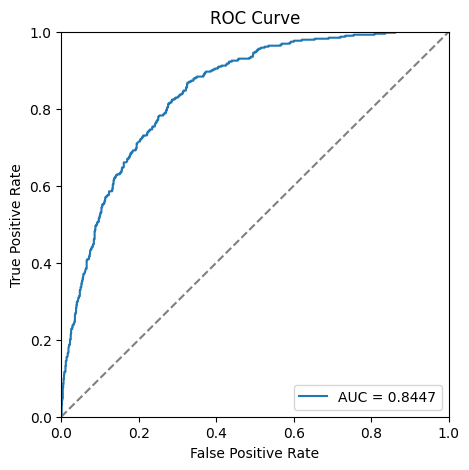

In [43]:
params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_estimators': 100,
    'scale_pos_weight': 3,
    'subsample': 0.9,
    'use_label_encoder': False, 
    'eval_metric': 'logloss'
}

model = xgb.XGBClassifier(random_state=rs, **params)
model.fit(features_train, target_train)

test_accuracy = model.score(features_test, target_test)
print("Accuracy on the test set:", test_accuracy)

probabilities_test = model.predict_proba(features_test)[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_test)
auc_roc = roc_auc_score(target_test, probabilities_test)
print('AUC-ROC:', auc_roc)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc_roc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Conclusion

The the final XGBoost model was evaluated as part of the churn prediction task and achieved an accuracy of 0.7388 on the test set, along with an AUC-ROC score of 0.8447. These results indicate that while the model performs reasonably well in identifying churned versus non-churned customers, there is room for improvement. The AUC-ROC score suggests that the model has a good balance between sensitivity and specificity, making it effective in distinguishing between positive and negative cases. However, the relatively lower accuracy highlights that further fine-tuning or additional feature engineering might be necessary to enhance its overall predictive performance. Despite this, the XGBoost model remains a solid choice, particularly if computational efficiency and handling of imbalanced classes are priorities.

# Final Report

The churn prediction task involved several key steps, beginning with data preprocessing, exploratory data analysis, and model selection. Throughout the process, the focus was on transforming the raw data into a format suitable for machine learning models and then selecting and fine-tuning those models for optimal performance. One of the critical decisions was to skip the step of upsampling or downsampling the data. Initially, the plan included balancing the classes to address the issue of class imbalance, which can often lead to biased models. However, after experimenting with both upsampling and downsampling techniques, it became evident that these approaches negatively impacted the model's performance, leading to lower ROC-AUC and accuracy scores. As a result, this step was omitted to maintain the integrity of the model's predictive capabilities.

Several challenges arose during the project, particularly in choosing the appropriate method for encoding categorical variables and correctly applying the upsampling/downsampling techniques. These difficulties were managed by systematically evaluating and comparing different encoding methods and analyzing the impact of class balancing on the model's performance. By focusing on methods that produced the best results, these challenges were effectively overcome, leading to more accurate predictions.

Key steps in solving the task included thorough data preprocessing, feature engineering, and careful model selection. The iterative process of testing various models and tuning hyperparameters was crucial in identifying the best-performing model. The final model chosen for this task was the XGBClassifier, which achieved a ROC-AUC score of 0.8446. This model stood out due to its ability to balance performance and accuracy, making it the best candidate for predicting customer churn in this context.

Side note: The comment left by the reviewer mentioned I deleted comments they left, however those comments were not included because I modified the original file in VSCode.